# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [63]:
from dataset import load_svhn
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [5]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

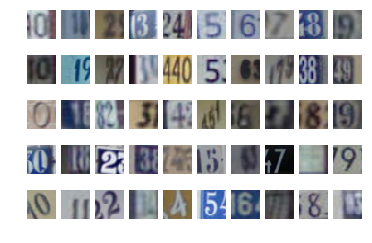

In [6]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [7]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [8]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

NameError: name 'KNN' is not defined

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

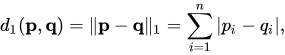

In [64]:
class KNN:
    """
    K-neariest-neighbor classifier using L1 loss
    """
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X, num_loops=0):
        '''
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use

        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        '''
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        else:
            dists = self.compute_distances_two_loops(X)

        if self.train_y.dtype == np.bool:
            return self.predict_labels_binary(dists)
        else:
            return self.predict_labels_multiclass(dists)

    def compute_distances_two_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            for i_train in range(num_train):
                dists[i_test][i_train] = np.sum(np.fabs(X[i_test] - self.train_X[i_train]))
        return dists

    def compute_distances_one_loop(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            dists[i_test] = np.sum(np.fabs(self.train_X - X[np.newaxis, i_test]), axis=1)
        return dists

    def compute_distances_no_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        # Using float32 to to save memory - the default is float64
        dists = np.zeros((num_test, num_train), np.float32)
        return np.sum(np.fabs(X[:, np.newaxis, :] - self.train_X), axis=-1)

    def predict_labels_binary(self, dists):
        '''
        Returns model predictions for binary classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for every test sample
        '''
        ind = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        pred = [np.bincount(self.train_y[i]).argmax() for i in ind]
        return pred


    def predict_labels_multiclass(self, dists):
        '''
        Returns model predictions for multi-class classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        '''
        ind = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        pred = [np.bincount(self.train_y[i]).argmax() for i in ind]
        return pred


In [65]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

In [14]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [15]:
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [16]:
# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [17]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

61.7 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.1 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.1 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [72]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.62, Precision: 0.75, Recall: 0.75, F1: 0.75


In [73]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.62, Precision: 0.83, Recall: 0.71, F1: 0.77


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [74]:
class KFold:
    def __init__(self, n_splits=3, shuffle=False, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def set_params(self, n_splits: int):
        self.n_splits = n_splits

    def split(self, X: np.array, y=None):
        if self.shuffle:
            np.random.shuffle(X)

        k_size = int(X.shape[0] / self.n_splits)
        indexes = np.arange(X.shape[0])
        start = 0
        stop = k_size
        y_folds, X_folds = list(), list()

        for _ in np.arange(self.n_splits):
            y_k = indexes[start:stop]
            X_k = np.setdiff1d(indexes, y_k)
            y_folds.append(y_k)
            X_folds.append(X_k)
            start = stop
            stop += k_size

        for X_idx, y_idx in zip(X_folds, y_folds):
            yield X_idx, y_idx


In [75]:
cv = KFold(n_splits=5, shuffle=True)

In [76]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for train_ind, test_ind in cv.split(binary_train_X):
    temp_f = []
    for k in k_choices:
        knn = KNN(k=k)
        knn.fit(binary_train_X[train_ind], binary_train_y[train_ind])
        f1 = binary_classification_metrics(knn.predict(binary_train_X[test_ind]), binary_train_y[test_ind])[2]
        temp_f.append(f1)
    k_to_f1[k] = np.mean(temp_f)

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 50, f1 = 0.628567


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [77]:
# TODO Set the best k to the best value found by cross-validation
best_k = 50

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 50
Accuracy: 0.62, Precision: 0.67, Recall: 0.80, F1: 0.73


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [78]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [79]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [80]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [81]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for train_ind, test_ind in cv.split(binary_train_X):
    temp_f = []
    for k in k_choices:
        knn = KNN(k=k)
        knn.fit(binary_train_X[train_ind], binary_train_y[train_ind])
        f1 = binary_classification_metrics(knn.predict(binary_train_X[test_ind]), binary_train_y[test_ind])[0]
        temp_f.append(f1)
    k_to_f1[k] = np.mean(temp_f)

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 50, f1 = 0.357143


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [82]:
# TODO Set the best k as a best from computed
best_k = 50

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.14
